#### Example running SpaFHy with jupyter notebook for Pallas catchment(s)

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
SpaFHy_folder = os.getenv('SPAFHY_V2_FOLDER')
os.chdir(SpaFHy_folder)

from model_driver import parallel_driver
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

###############################################################################
# example parameters to run single catchment or multiple catchments in parallel
catchment = 'krycklan' # 'krycklan' / 'pallas' / 'hyytiala'
run_multiple = False # run multiple catchments in parallel (Boolean)
run_one = 12 # run one specific subcatchment (if pallas, 2 = lonmpolonjängänoja)
folder = f'/Users/jpnousu/SpaFHy_RUNS/{catchment}' # input/output directory
###############################################################################

# setting up subcatchments in catchment_no
if run_multiple: # running multiple catchments as in catchment_no
    if catchment == 'pallas':
        catchment_no = np.arange(2,13,1)
    elif catchment == 'krycklan':
        catchment_no = np.arange(1,23,1)
        exclude = [11, 17, 18, 19]
        catchment_no = np.setdiff1d(catchment_no, exclude)
else:
    catchment_no = run_one

outputfile = parallel_driver(catchment, catchment_no, create_ncf=True, create_spinup=False, output=True, folder=folder)

# Reading the .nc results file that was just created
results = xr.open_dataset(outputfile[0])

*** Catchment no.: 12 ***
*** Defined root soil IDs: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11} Used root soil IDs: {1.0, 3.0, 4.0, 5.0, 6.0, 8.0} ***
*** Defined organic soil IDs: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11} Used organic soil IDs: {1.0, 3.0, 4.0, 5.0, 6.0, 8.0} ***
*** Defined deep soil IDs: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11} Used soil IDs: {1.0, 3.0, 4.0, 5.0, 6.0, 8.0}
*** State variables assigned from parameters.py ***
*** Simulation forced with: /Users/jpnousu/SpaFHy_RUNS/krycklan/forcing/FORCING.csv
*** Running model ***
*** 2D run
*** Bucket organic layer drains according to Campbell 1985
Running timestep:  1
Timestep: 1 , iterations: 4 , conv1: 6.497485640011291e-05 , H[max_index]: -2.550633334322754
Running timestep:  2
Timestep: 2 , iterations: 4 , conv1: 0.0001584331790240867 , H[max_index]: -1.3791787573572378
Running timestep:  3
Timestep: 3 , iterations: 6 , conv1: 3.577560602252561e-05 , H[max_index]: -3.742235893225228
Running timestep:  4
Timestep: 4 , iterations: 4 

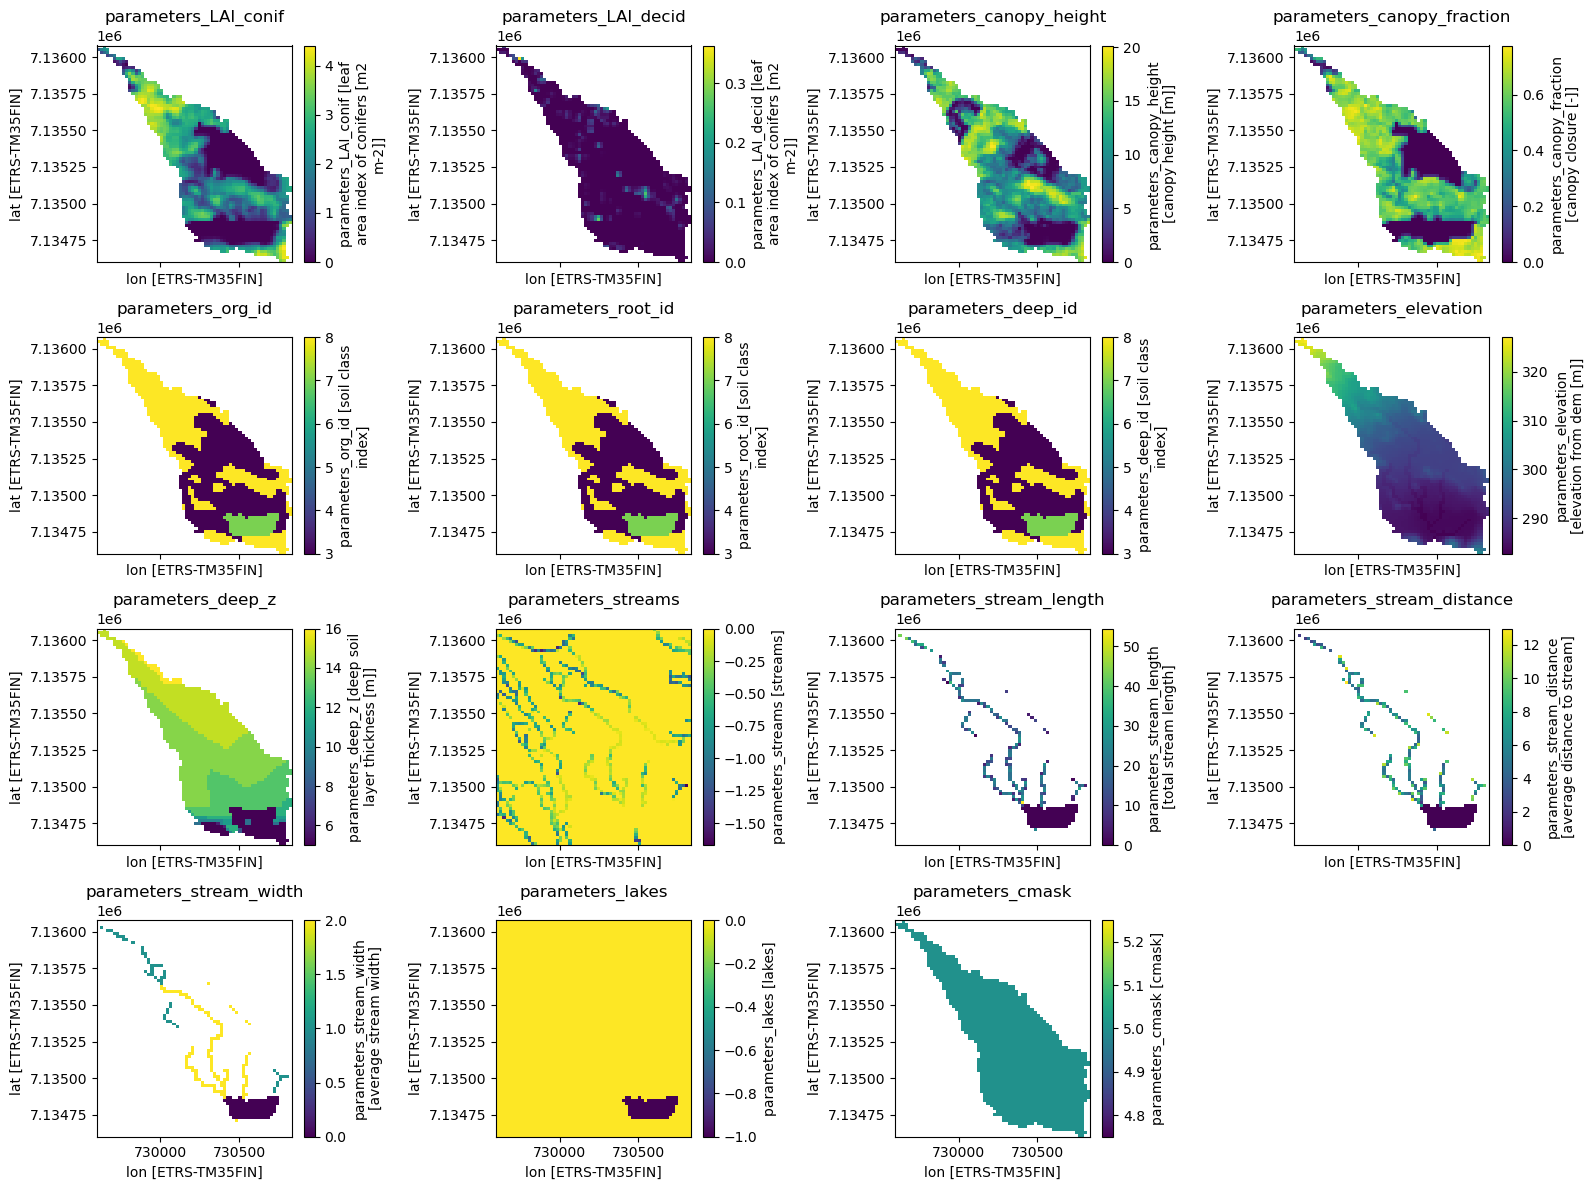

In [ ]:
import math

# Collect all keys starting with "parameters_"
param_keys = [k for k in results.keys() if k.startswith("parameters_")]

# Grid setup: 4 columns, rows computed automatically
ncols = 4
nrows = math.ceil(len(param_keys) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharex=True)

axes = axes.flatten()

for ax, key in zip(axes, param_keys):
    results[key].plot(ax=ax)
    ax.set_title(key)

for ax in axes[len(param_keys):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


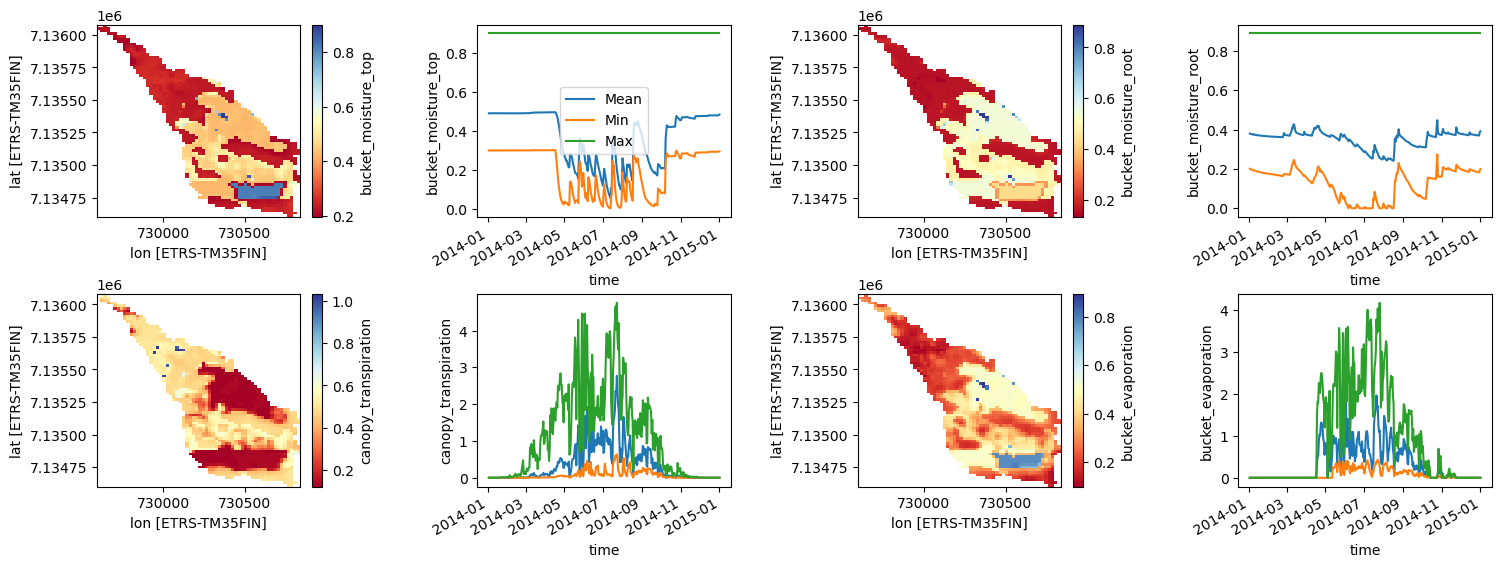

In [ ]:
# example plot 1 (works for 1D, TOP, or 2D simulation)

fig, axes = plt.subplots(2, 4, figsize=(18, 6))  # 2 rows, 4 columns
axes = axes.flatten()  # Flatten to easily index 0–7

# Plot 1
results['bucket_moisture_top'].mean(dim='time').plot(ax=axes[0], cmap='RdYlBu')

# Plot 2
results['bucket_moisture_top'].mean(dim=['lat', 'lon']).plot(ax=axes[1], label='Mean')
results['bucket_moisture_top'].min(dim=['lat', 'lon']).plot(ax=axes[1], label='Min')
results['bucket_moisture_top'].max(dim=['lat', 'lon']).plot(ax=axes[1], label='Max')
axes[1].legend()
# Plot 3
results['bucket_moisture_root'].mean(dim='time').plot(ax=axes[2], cmap='RdYlBu')

# Plot 4
results['bucket_moisture_root'].mean(dim=['lat', 'lon']).plot(ax=axes[3], label='Mean')
results['bucket_moisture_root'].min(dim=['lat', 'lon']).plot(ax=axes[3], label='Min')
results['bucket_moisture_root'].max(dim=['lat', 'lon']).plot(ax=axes[3], label='Max')

# Plot 5
results['canopy_transpiration'].mean(dim='time').plot(ax=axes[4], cmap='RdYlBu')

# Plot 6
results['canopy_transpiration'].mean(dim=['lat', 'lon']).plot(ax=axes[5], label='Mean')
results['canopy_transpiration'].min(dim=['lat', 'lon']).plot(ax=axes[5], label='Min')
results['canopy_transpiration'].max(dim=['lat', 'lon']).plot(ax=axes[5], label='Max')

# Plot 7
results['bucket_evaporation'].mean(dim='time').plot(ax=axes[6], cmap='RdYlBu')

# Plot 8
results['bucket_evaporation'].mean(dim=['lat', 'lon']).plot(ax=axes[7], label='Mean')
results['bucket_evaporation'].min(dim=['lat', 'lon']).plot(ax=axes[7], label='Min')
results['bucket_evaporation'].max(dim=['lat', 'lon']).plot(ax=axes[7], label='Max')

# Plot 8
#results['parameters_streams'].plot(ax=axes[7])

plt.subplots_adjust(wspace=0.5, hspace=0.4)  # Adjust spacing between plots

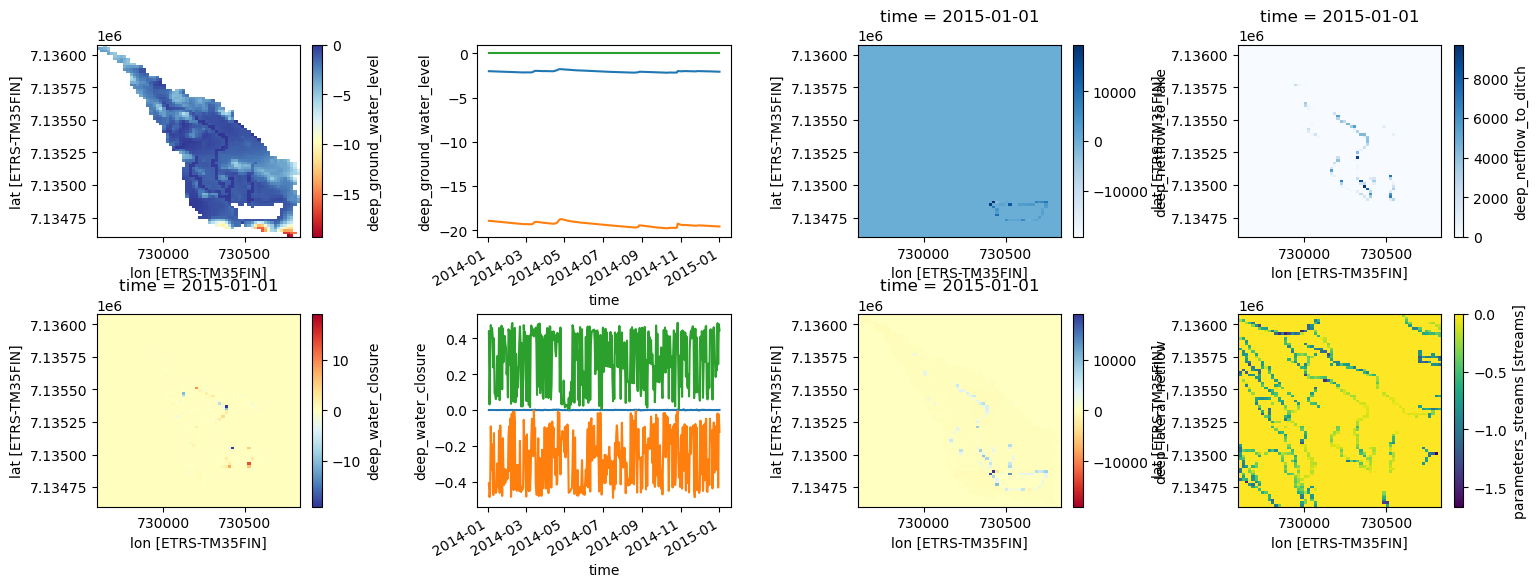

In [ ]:
# example plot 2 (works only for 2D simulation)

fig, axes = plt.subplots(2, 4, figsize=(18, 6))  # 2 rows, 4 columns
axes = axes.flatten()  # Flatten to easily index 0–7

# Plot 1
results['deep_ground_water_level'].mean(dim='time').plot(ax=axes[0], cmap='RdYlBu')

# Plot 2
results['deep_ground_water_level'].mean(dim=['lat', 'lon']).plot(ax=axes[1], label='Mean')
results['deep_ground_water_level'].min(dim=['lat', 'lon']).plot(ax=axes[1], label='Min')
results['deep_ground_water_level'].max(dim=['lat', 'lon']).plot(ax=axes[1], label='Max')

# Plot 3
results['deep_netflow_to_lake'].cumsum(dim='time')[-1].plot(ax=axes[2], cmap='Blues')

# Plot 4
#results['deep_netflow_to_ditch'][0].plot(ax=axes[3])
results['deep_netflow_to_ditch'].cumsum(dim='time')[-1].plot(ax=axes[3], cmap='Blues')

# Plot 5
#results['deep_water_closure'][-1].plot(ax=axes[4])
results['deep_water_closure'].cumsum(dim='time')[-1].plot(ax=axes[4], cmap='RdYlBu_r')

# Plot 6
results['deep_water_closure'].mean(dim=['lat', 'lon']).plot(ax=axes[5], label='Mean')
results['deep_water_closure'].min(dim=['lat', 'lon']).plot(ax=axes[5], label='Min')
results['deep_water_closure'].max(dim=['lat', 'lon']).plot(ax=axes[5], label='Max')

# Plot 7
#results['deep_lateral_netflow'].min(dim='time').plot(ax=axes[6])
results['deep_lateral_netflow'].cumsum(dim='time')[-1].plot(ax=axes[6], cmap='RdYlBu')

# Plot 8
results['parameters_streams'].plot(ax=axes[7])

plt.subplots_adjust(wspace=0.5, hspace=0.4)  # Adjust spacing between plots

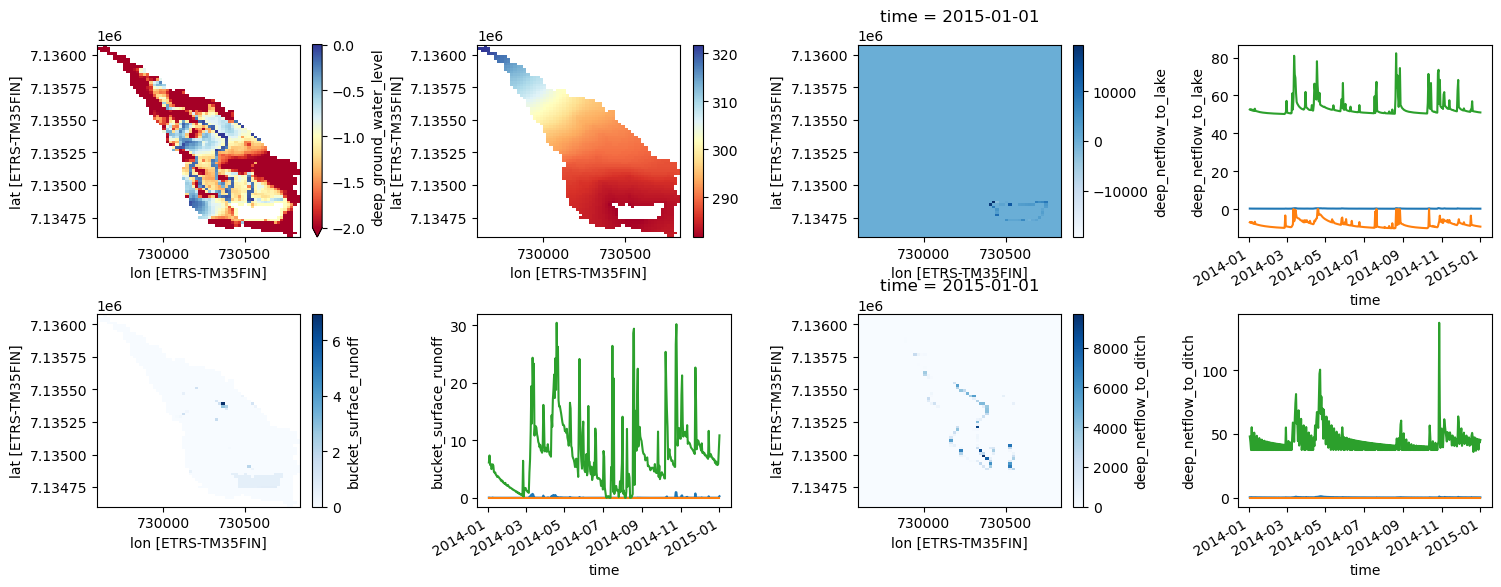

In [ ]:
# example plot 2 (works only for 2D simulation)

fig, axes = plt.subplots(2, 4, figsize=(18, 6))  # 2 rows, 4 columns
axes = axes.flatten()  # Flatten to easily index 0–7

# Plot 1
results['deep_ground_water_level'].mean(dim='time').plot(ax=axes[0], vmin=-2., cmap='RdYlBu')

# Plot 2
(results['parameters_elevation'] + results['deep_ground_water_level'].mean(dim='time')).plot(ax=axes[1], cmap='RdYlBu')


# Plot 3
results['deep_netflow_to_lake'].cumsum(dim='time')[-1].plot(ax=axes[2], cmap='Blues')

# Plot 4
#results['deep_netflow_to_ditch'][0].plot(ax=axes[3])
results['deep_netflow_to_lake'].mean(dim=['lat', 'lon']).plot(ax=axes[3], label='Mean')
results['deep_netflow_to_lake'].min(dim=['lat', 'lon']).plot(ax=axes[3], label='Min')
results['deep_netflow_to_lake'].max(dim=['lat', 'lon']).plot(ax=axes[3], label='Max')

# Plot 5
#results['deep_water_closure'][-1].plot(ax=axes[4])
results['bucket_surface_runoff'].mean(dim='time').plot(ax=axes[4], cmap='Blues')

# Plot 6
results['bucket_surface_runoff'].mean(dim=['lat', 'lon']).plot(ax=axes[5], label='Mean')
results['bucket_surface_runoff'].min(dim=['lat', 'lon']).plot(ax=axes[5], label='Min')
results['bucket_surface_runoff'].max(dim=['lat', 'lon']).plot(ax=axes[5], label='Max')

# Plot 7
#results['deep_lateral_netflow'].min(dim='time').plot(ax=axes[6])
results['deep_netflow_to_ditch'].cumsum(dim='time')[-1].plot(ax=axes[6], cmap='Blues')

# Plot 8
results['deep_netflow_to_ditch'].mean(dim=['lat', 'lon']).plot(ax=axes[7], label='Mean')
results['deep_netflow_to_ditch'].min(dim=['lat', 'lon']).plot(ax=axes[7], label='Min')
results['deep_netflow_to_ditch'].max(dim=['lat', 'lon']).plot(ax=axes[7], label='Max')

plt.subplots_adjust(wspace=0.5, hspace=0.4)  # Adjust spacing between plots

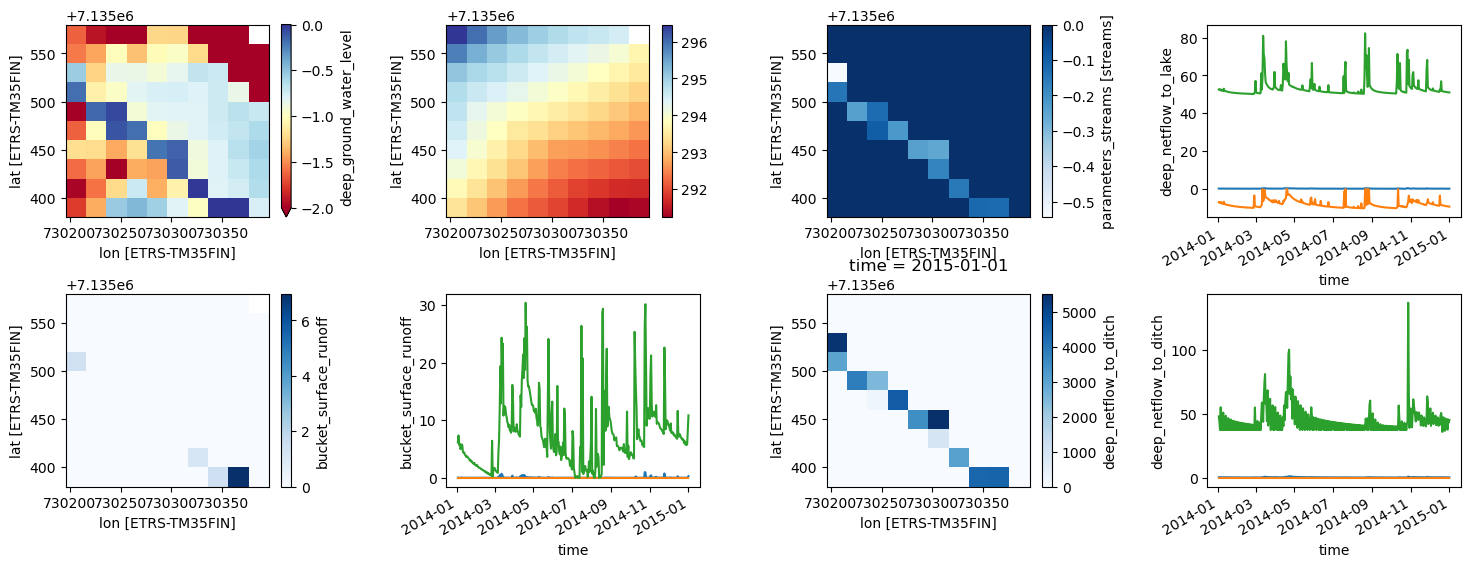

In [ ]:
# example plot 2 (works only for 2D simulation)

row_slice = slice(25, 35)
col_slice = slice(30, 40)

fig, axes = plt.subplots(2, 4, figsize=(18, 6))  # 2 rows, 4 columns
axes = axes.flatten()  # Flatten to easily index 0–7

# Plot 1
results['deep_ground_water_level'].mean(dim='time')[row_slice,col_slice].plot(ax=axes[0], vmin=-2., cmap='RdYlBu')

# Plot 2
(results['parameters_elevation'][row_slice, col_slice] + results['deep_ground_water_level'].mean(dim='time')[row_slice, col_slice]).plot(ax=axes[1], cmap='RdYlBu')


# Plot 3
results['parameters_streams'][row_slice, col_slice].plot(ax=axes[2], cmap='Blues')

# Plot 4
#results['deep_netflow_to_ditch'][0].plot(ax=axes[3])
results['deep_netflow_to_lake'].mean(dim=['lat', 'lon']).plot(ax=axes[3], label='Mean')
results['deep_netflow_to_lake'].min(dim=['lat', 'lon']).plot(ax=axes[3], label='Min')
results['deep_netflow_to_lake'].max(dim=['lat', 'lon']).plot(ax=axes[3], label='Max')

# Plot 5
#results['deep_water_closure'][-1].plot(ax=axes[4])
results['bucket_surface_runoff'].mean(dim='time')[row_slice,col_slice].plot(ax=axes[4], cmap='Blues')

# Plot 6
results['bucket_surface_runoff'].mean(dim=['lat', 'lon']).plot(ax=axes[5], label='Mean')
results['bucket_surface_runoff'].min(dim=['lat', 'lon']).plot(ax=axes[5], label='Min')
results['bucket_surface_runoff'].max(dim=['lat', 'lon']).plot(ax=axes[5], label='Max')

# Plot 7
#results['deep_lateral_netflow'].min(dim='time').plot(ax=axes[6])
results['deep_netflow_to_ditch'].cumsum(dim='time')[-1,row_slice, col_slice].plot(ax=axes[6], cmap='Blues')

# Plot 8
results['deep_netflow_to_ditch'].mean(dim=['lat', 'lon']).plot(ax=axes[7], label='Mean')
results['deep_netflow_to_ditch'].min(dim=['lat', 'lon']).plot(ax=axes[7], label='Min')
results['deep_netflow_to_ditch'].max(dim=['lat', 'lon']).plot(ax=axes[7], label='Max')

plt.subplots_adjust(wspace=0.5, hspace=0.4)  # Adjust spacing between plots

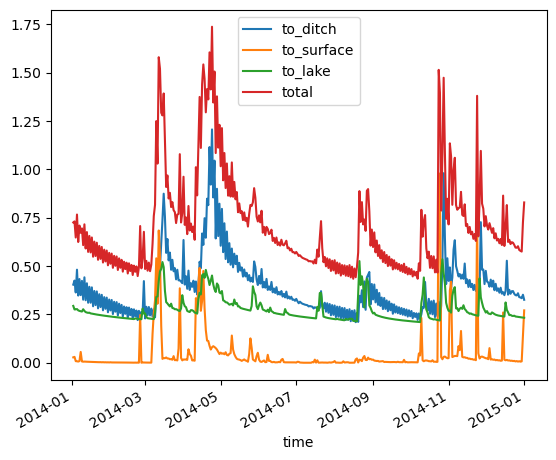

In [ ]:
results['deep_netflow_to_ditch'].mean(dim=['lat','lon']).plot(label='to_ditch')
results['bucket_surface_runoff'].mean(dim=['lat','lon']).plot(label='to_surface')
results['deep_netflow_to_lake'].mean(dim=['lat','lon']).plot(label='to_lake')
(results['deep_netflow_to_ditch'].mean(dim=['lat','lon']) + 
 results['bucket_surface_runoff'].mean(dim=['lat','lon']) + 
 results['deep_netflow_to_lake'].mean(dim=['lat','lon'])).plot(label='total')
plt.legend()